In [1]:
!pip install cvxpy

In [2]:
import numpy as np
import cvxpy as cp
import enum
import math
import cv2
from matplotlib import pyplot as plt

# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("Setup complete.")

Setup complete.


## Types of norms (L0, L1, L2)
Specifies which norm will be used for the attack & defense evaluation for Area scaling.
 
 L0, L1, or L2 norm.

In [12]:
class AreaNormEnumType(enum.Enum):
    L0 = 0
    L1 = 1
    L2 = 2

## Area Scaling Integer Borders Attack

Attacks image for the AREA scaling algorithm. 

It interprets the problem as an optimization problem, with min (x - src-img) s.th. 0 <= x <= 255 and 1/n * sum(x) = target-values where n is the respective block.

In source image whose average value is used to obtain the target value during the downscaling area operation.

    L1/L2 attack variant against Area scaling. Divides the image into several larger blocks where optimization problem is solved to get attack image.It is faster than 'area_direct' (which solves each block).

In [15]:
def area_direct_blockwise_int(tar_image: np.ndarray, src_img: np.ndarray, ksizex:int, ksizey: int, verbose: bool,
                              eps: int, attack_norm: AreaNormEnumType):
    src_img_new = np.zeros(src_img.shape)
    use_l2: bool = (attack_norm == AreaNormEnumType.L2) # otherwise, use L1

    def get_step(tar_image_sh):
        for divi in range(20, 2, -1):
            if tar_image_sh % divi == 0:
                return int(tar_image_sh / divi)

    stepx = get_step(tar_image_sh=tar_image.shape[0])
    stepy = get_step(tar_image_sh=tar_image.shape[1])

    for r in range(0, tar_image.shape[0], stepx):
        for c in range(0, tar_image.shape[1], stepy):
            if verbose is True and c == 0:
                print("Iteration: {}, {}".format(r, c))

            target_value = tar_image[r:(r + stepx), c:(c + stepy)]

            novelpixels = cp.Variable((ksizex * stepx, ksizey * stepy))

            startx = r * ksizex
            endx = ((r + stepx) * ksizex)
            starty = c * ksizey
            endy = ((c + stepy) * ksizey)

            obj_vec = novelpixels - src_img[startx:endx, starty:endy]
            if use_l2:
                obj = (1 / 2) * cp.sum_squares(obj_vec)
            else:
                obj = cp.sum(cp.abs(obj_vec))

            constrs = []
            for rb, rtarind in zip(range(0, endx - startx, ksizex), range(stepx)):
                for cb, ctarind in zip(range(0, endy - starty, ksizey), range(stepy)):
                    temp_constr = cp.abs(cp.sum(novelpixels[rb:(rb + ksizex), cb:(cb + ksizey)]) - \
                                         (target_value[rtarind, ctarind] * ksizex * ksizey)) <= eps
                    constrs.append(temp_constr)

            constr2 = novelpixels <= 255
            constr3 = novelpixels >= 0

            prob = cp.Problem(cp.Minimize(obj), [*constrs, constr2, constr3])

            try:
                prob.solve()
            except:
                if verbose is True:
                    print("QSQP failed at {}, {}".format(r, c))
                try:
                    prob.solve(solver=cp.ECOS)
                except:
                    print("Could not solve with QSPS and ECOS at {}, {}".format(r, c))
                    raise Exception("Could not solve at {}, {}".format(r, c))

            if prob.status != cp.OPTIMAL and prob.status != cp.OPTIMAL_INACCURATE:
                print("Could only solve at {}, {} with status: {}".format(r, c, prob.status))
                raise Exception("Only solveable with infeasible/unbounded/optimal_inaccurate solution")

            assert prob is not None and novelpixels.value is not None
            src_img_new[startx:endx, starty:endy] = np.round(novelpixels.value)

    return src_img_new

def area_direct_int(tar_image: np.ndarray, src_img: np.ndarray, ksizex:int, ksizey: int, verbose: bool, eps: int,
                    attack_norm: AreaNormEnumType):
    src_img_new = np.zeros(src_img.shape)
    use_l2: bool = (attack_norm == AreaNormEnumType.L2)

    for r in range(tar_image.shape[0]):
        for c in range(tar_image.shape[1]):
            if verbose is True and r % 20 == 0 and c == 0:
                print("Iteration: {}, {}".format(r, c))

            target_value = tar_image[r, c]

            novelpixels = cp.Variable(ksizex * ksizey)
            startx = r * ksizex
            endx = ((r + 1) * ksizex)
            starty = c * ksizey
            endy = ((c + 1) * ksizey)
            obj_vec = novelpixels - src_img[startx:endx, starty:endy].reshape(-1)

            if use_l2:
                obj = (1 / 2) * cp.quad_form(obj_vec, np.identity(ksizex * ksizey))
            else:
                obj = cp.sum(cp.abs(obj_vec))

            constr1 = cp.abs(cp.sum(novelpixels) - (target_value * ksizex * ksizey)) <= eps
            constr2 = novelpixels <= 255
            constr3 = novelpixels >= 0

            prob = cp.Problem(cp.Minimize(obj), [constr1, constr2, constr3])

            try:
                prob.solve()
            except:
                if verbose is True:
                    print("QSQP failed at {}, {}".format(r, c))
                try:
                    prob.solve(solver=cp.ECOS)
                except:
                    print("Could not solve with QSPS and ECOS at {}, {}".format(r, c))
                    raise Exception("Could not solve at {}, {}".format(r, c))

            if prob.status != cp.OPTIMAL and prob.status != cp.OPTIMAL_INACCURATE:
                print("Could only solve at {}, {} with status: {}".format(r, c, prob.status))
                raise Exception("Only solveable with infeasible/unbounded/optimal_inaccurate solution")
            assert prob is not None and novelpixels.value is not None

            src_img_new[startx:endx, starty:endy] = np.round(novelpixels.value.reshape((ksizex, ksizey)))

    return src_img_new

def area_scale_attack_integerborders(tar_image: np.ndarray, src_img: np.ndarray, verbose: bool,
                                     attack_norm: AreaNormEnumType, eps: int = 1, blockwise: bool = True):
    scalex = int(src_img.shape[0] / tar_image.shape[0])
    scaley = int(src_img.shape[1] / tar_image.shape[1])

    if scalex != round(src_img.shape[0] / tar_image.shape[0], 2) or\
        scaley != round(src_img.shape[1] / tar_image.shape[1], 2):
        raise NotImplementedError("This method expects that scaling ratio is an integer")

    assert isinstance(attack_norm, AreaNormEnumType)
    assert attack_norm == AreaNormEnumType.L1 or attack_norm == AreaNormEnumType.L2

    if len(src_img.shape) == 2:
        if blockwise is True:
            return area_direct_blockwise_int(tar_image=tar_image, src_img=src_img, ksizex=scalex, ksizey=scaley,
                                             verbose=verbose, eps=eps, attack_norm=attack_norm)
        else:
            return area_direct_int(tar_image=tar_image, src_img=src_img, ksizex=scalex, ksizey=scaley,
                                   verbose=verbose, eps=eps, attack_norm=attack_norm)
    else:
        ret = np.zeros(src_img.shape).astype(np.uint8)
        for ch in range(src_img.shape[2]):
            if blockwise is True:
                ret[:, :, ch] = area_direct_blockwise_int(tar_image=tar_image[:, :, ch], src_img=src_img[:, :, ch],
                                                          ksizex=scalex, ksizey=scaley, verbose=verbose, eps=eps,
                                                          attack_norm=attack_norm)
            else:
                ret[:, :, ch] = area_direct_int(tar_image=tar_image[:, :, ch], src_img=src_img[:, :, ch], ksizex=scalex,
                                                ksizey=scaley, verbose=verbose, eps=eps, attack_norm=attack_norm)
        return ret


## Area Scaling Non-Integer Borders Attack

It handles overlapping blocks and computes a solution for each block.

perform the attack by optimizing the pixel values to match the target image when downscaled.

In [16]:
def __get_weights_subblock(startrb, endrb, startcb, endcb, area):
    rx = np.round(startrb, 5)
    rx2 = np.round(endrb, 5)
    cx = np.round(startcb, 5)
    cx2 = np.round(endcb, 5)

    rx_left = math.floor(rx)
    rx_right = math.ceil(rx2)
    cx_left = math.floor(cx)
    cx_right = math.ceil(cx2)

    weights = np.ones((int(rx_right - rx_left), int(cx_right - cx_left)))
    if rx != rx_left:
        weights[0, :] = (math.ceil(rx) - rx)
    if rx2 != rx_right:
        weights[-1, :] = (rx2 - math.floor(rx2))
    if cx != cx_left:
        weights[:, 0] *= (math.ceil(cx) - cx)
    if cx2 != cx_right:
        weights[:, -1] *= (cx2 - math.floor(cx2))

    weights /= area
    assert np.round(np.sum(weights), 4) == 1.0

    return weights, rx_left, rx_right, cx_left, cx_right

def __area_direct_blockwise_nonintegerborders(tar_image: np.ndarray, src_img: np.ndarray,
                                            verbose: bool, eps: int, blockwise: float,
                                            attack_norm: AreaNormEnumType) -> np.ndarray:
    scalex = src_img.shape[0] / tar_image.shape[0]
    scaley = src_img.shape[1] / tar_image.shape[1]

    def get_integer_blocksize(scalefactor, max_shape):
        for k in range(1, max_shape):
            if k * scalefactor % 2 == 0 or k * scalefactor % 1 == 0:
                return int(k * scalefactor)
        raise Exception("Should not happen")

    blockwidth_x = get_integer_blocksize(scalefactor=scalex, max_shape=src_img.shape[0])
    blockwidth_y = get_integer_blocksize(scalefactor=scaley, max_shape=src_img.shape[1])

    def get_opt_blocks(src_image_sh, block_size, min_blocks):
        blocks = src_image_sh / block_size
        return int(max(1, np.floor(blocks * min_blocks)))

    opt_block_step_widthx = get_opt_blocks(src_image_sh=src_img.shape[0], block_size=blockwidth_x, min_blocks=blockwise)
    opt_block_step_widthy = get_opt_blocks(src_image_sh=src_img.shape[1], block_size=blockwidth_y, min_blocks=blockwise)

    area = scalex * scaley
    src_img_new = np.zeros(src_img.shape)

    subblocksx = int(opt_block_step_widthx * (blockwidth_x / scalex))
    subblocksy = int(opt_block_step_widthy * (blockwidth_y / scaley))

    if verbose is True:
        print("We use {} blocks in one opti-block in x-dir (y-dir: {})".
              format(opt_block_step_widthx, opt_block_step_widthy))
        print("Each block consists of {} sub-blocks, each opti-block of {} sub-blocks, {} pixels each (y-dir: {},{},{})".
              format(blockwidth_x / scalex, subblocksx, scalex, blockwidth_y / scaley, subblocksy, scaley))

    for r in range(0, tar_image.shape[0], subblocksx):
        for c in range(0, tar_image.shape[1], subblocksy):
            rborder = np.minimum(tar_image.shape[0], r + subblocksx)
            cborder = np.minimum(tar_image.shape[1], c + subblocksy)

            target_value = tar_image[r:rborder, c:cborder]

            src_startx = int(r * scalex)
            src_endx = int(rborder * scalex)
            src_starty = int(c * scaley)
            src_endy = int(cborder * scaley)

            if verbose is True:
                print("x:x', y:y'; Tar: {}:{}, {}:{}; Src: {}:{}, {}:{}".
                      format(r, rborder, c, cborder, src_startx, src_endx, src_starty, src_endy))

            novelpixels = cp.Variable((src_endx - src_startx, src_endy - src_starty))

            obj_vec = novelpixels - src_img[src_startx:src_endx, src_starty:src_endy]
            if attack_norm == AreaNormEnumType.L2:
                obj = (1 / 2) * cp.sum_squares(obj_vec)
            elif attack_norm == AreaNormEnumType.L1:
                obj = cp.sum(cp.abs(obj_vec))
            else:
                raise NotImplementedError()

            constraints_subblocks = []
            for rtar, src_rb in enumerate(np.arange(0, src_endx - src_startx, scalex)):
                for ctar, src_cb in enumerate(np.arange(0, src_endy - src_starty, scaley)):
                    subblock_weights, rx_left, rx_right, cx_left, cx_right = __get_weights_subblock(
                        startrb=src_rb, endrb=src_rb + scalex,
                        startcb=src_cb, endcb=src_cb + scaley,
                        area=area)

                    t_w = cp.sum(cp.multiply(novelpixels[rx_left:rx_right, cx_left:cx_right], subblock_weights))
                    temp_constr = cp.abs(t_w - target_value[rtar, ctar]) <= eps

                    constraints_subblocks.append(temp_constr)

            constr2 = novelpixels <= 255
            constr3 = novelpixels >= 0
            prob = cp.Problem(cp.Minimize(obj), [*constraints_subblocks, constr2, constr3])

            try:
                prob.solve(solver=cp.OSQP)
            except:
                if verbose is True:
                    print("QSQP failed")
                try:
                    prob.solve(solver=cp.ECOS)
                except:
                    print("Could not solve with QSPS and ECOS at {}, {}".format(r, c))
                    raise Exception("Could not solve at {}, {}".format(r, c))
            if prob.status != cp.OPTIMAL and prob.status != cp.OPTIMAL_INACCURATE:
                print("Could only solve at {}, {} with status: {}".format(r, c, prob.status))
                raise Exception("Only solveable with infeasible/unbounded/optimal_inaccurate solution")

            src_img_new[src_startx:src_endx, src_starty:src_endy] = np.round(novelpixels.value)

    return src_img_new

def area_scale_attack_nonintegerborders(tar_image: np.ndarray,
                                        src_img: np.ndarray,
                                        verbose: bool,
                                        attack_norm: AreaNormEnumType,
                                        eps: int = 1,
                                        blockwise: float = 0.25) -> np.ndarray:
    assert 0 < blockwise < 1
    assert isinstance(attack_norm, AreaNormEnumType)
    assert attack_norm == AreaNormEnumType.L1 or attack_norm == AreaNormEnumType.L2

    if len(src_img.shape) == 2:
        return __area_direct_blockwise_nonintegerborders(tar_image=tar_image, src_img=src_img,
                                                         verbose=verbose, eps=eps, blockwise=blockwise,
                                                         attack_norm=attack_norm)
    else:
        ret = np.zeros(src_img.shape).astype(np.uint8)
        for ch in range(src_img.shape[2]):
            ret[:, :, ch] = __area_direct_blockwise_nonintegerborders(tar_image=tar_image[:, :, ch], src_img=src_img[:, :, ch],
                                                                      verbose=verbose, eps=eps,
                                                                      blockwise=blockwise, attack_norm=attack_norm)
        return ret


## Area Straight Scaling Attack

implements an L0-based attack against area scaling 

manipulates the pixel values based on their mean values within blocks.

coordinates the attack for both grayscale and color images.

In [17]:
def _area_straight_direct(tar_image: np.ndarray, src_img: np.ndarray, ksizex:int, ksizey: int, verbose: bool, permutation: bool):
    src_img_new = src_img.copy()
    rewritten_pixels = np.zeros(tar_image.shape)

    for r in range(tar_image.shape[0]):
        for c in range(tar_image.shape[1]):
            if verbose is True and r % 20 == 0 and c == 0:
                print("Iteration: {}, {}".format(r, c))

            startx = int(r * ksizex)
            endx = int((r + 1) * ksizex)
            starty = int(c * ksizey)
            endy = int((c + 1) * ksizey)

            region = src_img_new[startx:endx, starty:endy]
            region_mean = region.mean()

            if tar_image[r, c] == region_mean:
                continue
            elif tar_image[r, c] > region_mean:
                add = True
                mode_add = 255
            else:
                add = False
                mode_add = 0

            finished = False

            list_of_pairs = [(x, y) for x in range(region.shape[0]) for y in range(region.shape[1])]
            if permutation is True:
                np.random.seed(32 + 19 * r + c)
                np.random.shuffle(list_of_pairs)

            nochanged = 0
            for ri, ci in list_of_pairs:
                if finished is True:
                    break

                next_value = region_mean - \
                             src_img_new[ri + startx, ci + starty] / region.size + \
                             mode_add / region.size

                if add is True and next_value > tar_image[r, c]:
                    mode_add = tar_image[r, c] * region.size - \
                               region_mean * region.size + \
                               src_img_new[ri + startx, ci + starty]
                    finished = True
                if add is False and next_value < tar_image[r, c]:
                    mode_add = tar_image[r, c] * region.size - \
                               region_mean * region.size + \
                               src_img_new[ri + startx, ci + starty]
                    finished = True

                region_mean = region_mean - \
                              src_img_new[ri + startx, ci + starty] / region.size + \
                              mode_add / region.size
                src_img_new[ri + startx, ci + starty] = mode_add
                nochanged += 1

            rewritten_pixels[r, c] = nochanged / len(list_of_pairs)

    return src_img_new, rewritten_pixels

def area_straight_scale_attack(tar_image: np.ndarray, src_img: np.ndarray, verbose: bool, permutation: bool):
    scalex = int(src_img.shape[0] / tar_image.shape[0])
    scaley = int(src_img.shape[1] / tar_image.shape[1])

    if scalex != round(src_img.shape[0] / tar_image.shape[0], 2) or \
        scaley != round(src_img.shape[1] / tar_image.shape[1], 2):
        raise NotImplementedError("This method expects that scaling ratio is an integer")

    if len(src_img.shape) == 2:
        return _area_straight_direct(tar_image=tar_image, src_img=src_img, ksizex=scalex, ksizey=scaley, verbose=verbose, permutation=permutation)
    else:
        ret = np.zeros(src_img.shape).astype(np.uint8)
        ret2 = np.zeros(tar_image.shape)
        for ch in range(src_img.shape[2]):
            ret[:, :, ch], ret2[:, :, ch] = _area_straight_direct(tar_image=tar_image[:, :, ch], src_img=src_img[:, :, ch],
                                                ksizex=scalex, ksizey=scaley, verbose=verbose, permutation=permutation)
        return ret, ret2


## Rescaling Area

In [18]:
def rescale_to_integer(noninteger: bool, src_image: np.ndarray, tar_image_shape: tuple, row: int) -> np.ndarray:
    if noninteger is True:
        src_image_example = src_image.copy()
    else:
        scalex = np.floor(src_image.shape[0] / tar_image_shape[0])
        scaley = np.floor(src_image.shape[1] / tar_image_shape[1])
        if scalex < 2.0 or scaley < 2.0:
            print("scale factor skipping", row)
            raise Exception("scale factor skipping")

        src_image_example = scale_utils.scale_cv2(src_image,
                                                  int(scalex * tar_image_shape[0]),
                                                  int(scaley * tar_image_shape[1]))

    return src_image_example

## Testing on a 70 speed limit sign

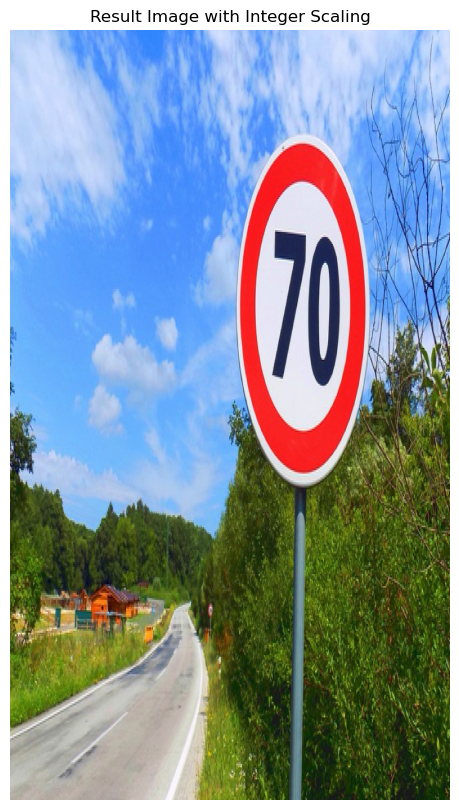

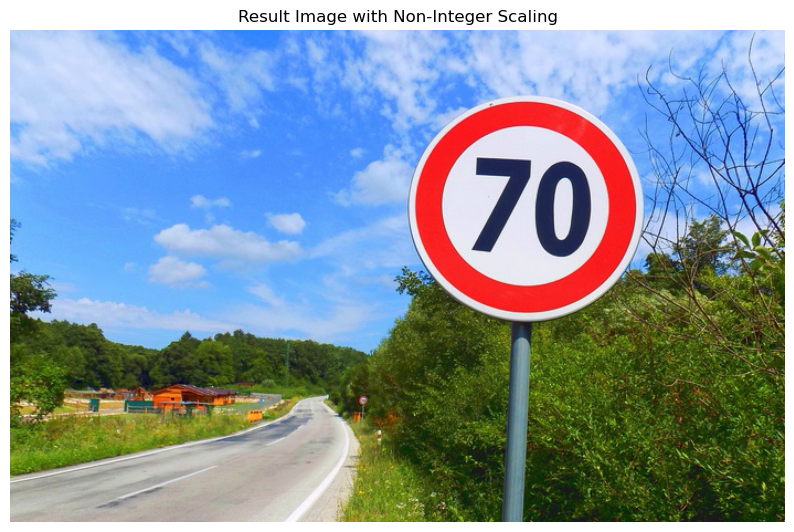

In [25]:
def scale_cv2(image, new_width, new_height):
    return cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

def rescale_to_integer(noninteger: bool, src_image: np.ndarray, tar_image_shape: tuple, row: int) -> np.ndarray:
    if noninteger is True:
        src_image_example = src_image.copy()
    else:
        scalex = np.floor(src_image.shape[0] / tar_image_shape[0])
        scaley = np.floor(src_image.shape[1] / tar_image_shape[1])
        if scalex < 2.0 or scaley < 2.0:
            print("scale factor skipping", row)
            raise Exception("scale factor skipping")

        src_image_example = scale_cv2(src_image,
                                      int(scalex * tar_image_shape[0]),
                                      int(scaley * tar_image_shape[1]))

    return src_image_example

def display_image(title, image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()


src_image = cv2.imread('C:/Users/wania/OneDrive/Desktop/GTSRB Dataset/pics/70.png')  
tar_image_shape = (100, 100) 

# Test the function with integer scaling
try:
    result_image_int = rescale_to_integer(False, src_image, tar_image_shape, 0)
    display_image('Result Image with Integer Scaling', result_image_int)
except Exception as e:
    print(e)

# Test the function with non-integer scaling
try:
    result_image_nonint = rescale_to_integer(True, src_image, tar_image_shape, 0)
    display_image('Result Image with Non-Integer Scaling', result_image_nonint)
except Exception as e:
    print(e)
